In [1]:
# !pip install numpy
# !pip install sympy 
# !pip install pandas
# !pip install openpyxl
# !pip install pyarrow

In [2]:
import numpy as np
import sympy as sy
import pandas as pd
import sys

In [3]:
# https://www.math.stonybrook.edu/~tony/tides/harmonic.html
# w is used in place of ω
# O is used in place of Ω
w1 = 15 # deg/hr
w2 = 0.54901653 # deg/hr
w3 = 0.04106864 # deg/hr
O = 2*(w1 - w2 + w3) # 28.984 deg/hr (from project description)

to_rads = np.pi / 180
to_degs = 180 / np.pi

h0, a, b = sy.symbols("h0,a,b")

In [4]:
bristol_data = pd.read_excel(sys.path[0] + "\..\TideData.xlsx", sheet_name = "Bristol")

donaghadee_data = pd.read_excel(sys.path[0] + "\..\TideData.xlsx", sheet_name = "Donaghadee")

In [5]:
def lin_eq(h, t):
    return sy.Eq(h0 + a*sy.cos(O*t*to_rads) + b*sy.sin(O*t*to_rads), h)


def solve_system(heights_times):
    eqs = []
    for h_t in heights_times:
        eqs.append(lin_eq(h_t[0], h_t[1]))
    return sy.solve([eqs[0], eqs[1], eqs[2]], (h0,a,b), dict=True)[0]

def solve_bristol(sp, inc):
    vals = [[bristol_data["h"][sp], bristol_data['t'][sp]], 
            [bristol_data['h'][sp+inc], bristol_data['t'][sp+inc]], 
            [bristol_data['h'][sp+2*inc], bristol_data['t'][sp+2*inc]]]

    sol = solve_system(vals)
    #sy.pprint(sol)
    return sol

def solve_donaghadee(sp, inc):
    vals = [[donaghadee_data["h"][sp], donaghadee_data['t'][sp]], 
            [donaghadee_data['h'][sp+inc], donaghadee_data['t'][sp+inc]], 
            [donaghadee_data['h'][sp+2*inc], donaghadee_data['t'][sp+2*inc]]]

    sol = solve_system(vals)
    #sy.pprint(sol)
    return sol

def pred_times_highs_lows(a, b, n):
    t = (1/O)*(np.arctan(float(b/a))+np.pi*n)*to_degs # get arg and convert it back into degrees, then use 1/Ω for t
    return t

def tide_high_or_low(a, b, t):
    hii_t = -a*O*O*np.cos(O*t*to_rads) - b*O*O*np.sin(O*t*to_rads)
    if hii_t > 0:
        return "low"
    else:
        return "high"
    
def pred_height(h0, a, b, t):
    return h0 + a*np.cos(to_rads*O*(t)) + b*np.sin(to_rads*O*(t))

### Bristol

In [6]:
predictions = {'Time' : [], 'Height' : [], 'High_or_Low' : []}
results = solve_bristol(sp = 0, inc = 5) # initial inc 1
#test_results(results)
for n in range(1, 55):
    t = pred_times_highs_lows(results[a], results[b], n)
    h = pred_height(h0 = results[h0], a = results[a], b = results[b], t = t)
    high_or_low = tide_high_or_low(results[a], results[b], t)
    predictions['Time'].append(t)
    predictions['Height'].append(h)
    predictions['High_or_Low'].append(high_or_low)
preds_df = pd.DataFrame(data = predictions)
preds_df.head()
#preds_df.to_csv("BristolPreds_attempt_3_each_5.csv")

,Time,Height,High_or_Low
0,3.814264,2.13647889474650,low
1,10.024565,11.9105917249330,high
2,16.234866,2.13647889474650,low
3,22.445166,11.9105917249330,high
4,28.655467,2.13647889474650,low


In [7]:
results

{h0: 7.02353530983976, a: 1.71571962691631, b: -4.57598367196806}

In [8]:
#bristol_data.head(28)

In [9]:
# inc1 = solve_bristol(sp = 0, inc = 1)
# sy.pprint(inc1)
# results_df = pd.DataFrame(data = inc1)
# additional_results = [solve_bristol(sp = 0, inc = 3), solve_bristol(sp = 0, inc = 5), solve_bristol(sp = 0, inc = 7), solve_bristol(sp = 0, inc = 9)]
# count = 1
# for r in additional_results:
#     sy.pprint(r)
#     results_df.loc[count] = r
#     count += 1


In [10]:
180/O

6.2103006059367525

In [11]:
# averaged_results = {a: 0.206152418, b: -3.953403392, h0: 6.933348862}
# results = averaged_results
# predictions = {'Time' : [], 'Height' : [], 'High_or_Low' : []}
# for n in range(1, 29):
#     t = pred_times_highs_lows(results[a], results[b], n)
#     h = pred_height(h0 = results[h0], a = results[a], b = results[b], t = t)
#     high_or_low = tide_high_or_low(results[a], results[b], t)
#     predictions['Time'].append(t)
#     predictions['Height'].append(h)
#     predictions['High_or_Low'].append(high_or_low)
# preds_df = pd.DataFrame(data = predictions)
# preds_df.to_csv("Averaged_Bristol_Preds.csv")

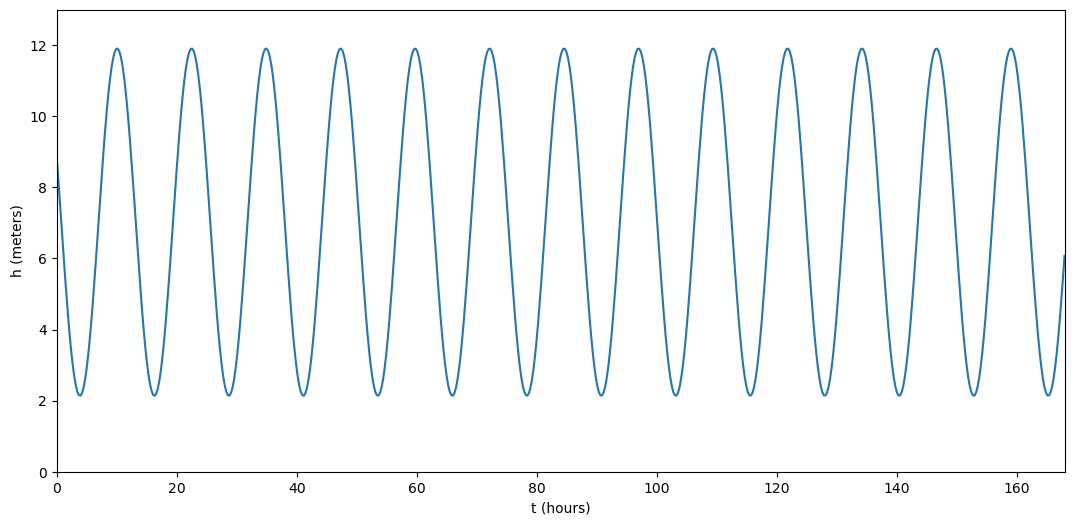

In [12]:
import matplotlib.pyplot as plt
def plot_equation(results):
    t_vals = np.linspace(0, 168, 650)
    h_vals = results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads)
    #print(h_vals)
    plt.figure(figsize=(13,6))
    p = plt.plot(t_vals, h_vals)
    plt.xlabel("t (hours)")
    plt.ylabel("h (meters)")
    ax = plt.gca()
    ax.set_xlim(0, 168)
    ax.set_ylim(0, 13)
    #plt.savefig("Bristol_Simple_168_long_b.pdf", bbox_inches='tight')
    return h_vals
    
h_vals = plot_equation(results)

In [13]:
compare_df = preds_df.join(bristol_data[["h","t"]])
compare_df["Time Error"] = compare_df["Time"] - compare_df["t"]
compare_df["Height Error"] = compare_df["Height"] - compare_df["h"]

In [14]:
compare_df.head(55)

,Time,Height,High_or_Low,h,t,Time Error,Height Error
0,3.814264,2.13647889474650,low,2.2,4.133333,-0.319069,-0.0635211052534963
1,10.024565,11.9105917249330,high,12.0,9.833333,0.191232,-0.0894082750669867
2,16.234866,2.13647889474650,low,2.4,16.366667,-0.131801,-0.263521105253496
3,22.445166,11.9105917249330,high,11.7,22.116667,0.328499,0.210591724933014
4,28.655467,2.13647889474650,low,2.3,28.450000,0.205467,-0.163521105253496
5,34.865767,11.9105917249330,high,11.7,34.283333,0.582434,0.210591724933014
6,41.076068,2.13647889474650,low,2.4,40.700000,0.376068,-0.263521105253496
7,47.286369,11.9105917249330,high,11.4,46.566667,0.719702,0.510591724933013
8,53.496669,2.13647889474650,low,2.4,52.866667,0.630003,-0.263521105253496
9,59.706970,11.9105917249330,high,11.5,58.750000,0.956970,0.410591724933013


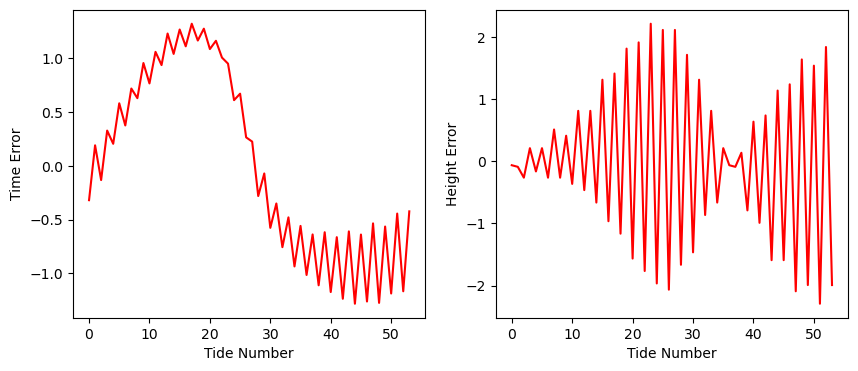

In [15]:
plt.gcf().set_size_inches((10, 4))
ax1 = plt.subplot(121)
plt.plot(compare_df["Time Error"], 'r')
plt.xlabel("Tide Number")
plt.ylabel("Time Error")
ax2 = plt.subplot(122, adjustable='box')
plt.plot(compare_df["Height Error"], 'r')
plt.xlabel("Tide Number")
plt.ylabel("Height Error")
plt.savefig("BristolSimpleErrors.pdf", bbox_inches='tight')

### Donaghadee

In [16]:
predictions = {'Time' : [], 'Height' : [], 'High_or_Low' : []}
results = solve_donaghadee(sp = 0, inc = 7) # initial inc 1
for n in range(0, 54):
    t = pred_times_highs_lows(results[a], results[b], n)
    h = pred_height(h0 = results[h0], a = results[a], b = results[b], t = t)
    high_or_low = tide_high_or_low(results[a], results[b], t)
    predictions['Time'].append(t)
    predictions['Height'].append(h)
    predictions['High_or_Low'].append(high_or_low)
preds_df = pd.DataFrame(data = predictions)
preds_df.head()

,Time,Height,High_or_Low
0,1.686229,3.43238046793739,high
1,7.896530,0.689765375475623,low
2,14.106830,3.43238046793739,high
3,20.317131,0.689765375475623,low
4,26.527432,3.43238046793739,high


In [17]:
results

{h0: 2.06107292170650, a: 0.901935358916660, b: 1.03295546597404}

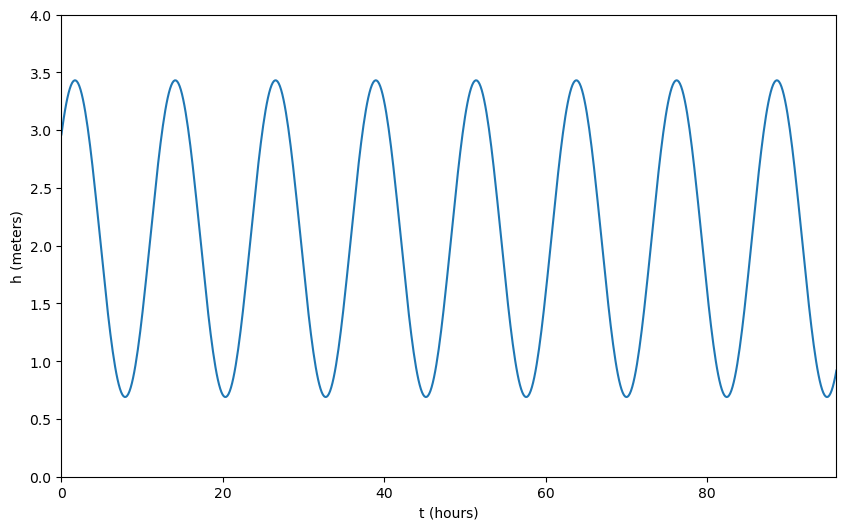

In [22]:
import matplotlib.pyplot as plt
def plot_equation_d(results):
    t_vals = np.linspace(0, 96, 650)
    h_vals = results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads)
    #print(h_vals)
    plt.figure(figsize=(10,6))
    p = plt.plot(t_vals, h_vals)
    plt.xlabel("t (hours)")
    plt.ylabel("h (meters)")
    ax = plt.gca()
    ax.set_xlim(0, 96)
    ax.set_ylim(0, 4)
    plt.savefig("Donaghadee_4_days.pdf", bbox_inches='tight')
    return h_vals
    
h_vals = plot_equation_d(results)

In [19]:
compare_df = preds_df.join(donaghadee_data[["h","t"]])
compare_df["Time Error"] = compare_df["Time"] - compare_df["t"]
compare_df["Height Error"] = compare_df["Height"] - compare_df["h"]

In [20]:
compare_df

,Time,Height,High_or_Low,h,t,Time Error,Height Error
0,1.686229,3.43238046793739,high,3.4,2.116667,-0.430438,0.0323804679373860
1,7.896530,0.689765375475623,low,0.8,7.966667,-0.070137,-0.110234624524377
2,14.106830,3.43238046793739,high,4.0,14.316667,-0.209836,-0.567619532062614
3,20.317131,0.689765375475623,low,0.7,20.300000,0.017131,-0.0102346245243767
4,26.527432,3.43238046793739,high,3.4,26.683333,-0.155902,0.0323804679373860
5,32.737732,0.689765375475623,low,0.8,32.583333,0.154399,-0.110234624524377
6,38.948033,3.43238046793739,high,3.9,38.883333,0.064699,-0.467619532062614
7,45.158333,0.689765375475623,low,0.7,44.916667,0.241667,-0.0102346245243766
8,51.368634,3.43238046793739,high,3.4,51.283333,0.085301,0.0323804679373865
9,57.578935,0.689765375475623,low,0.9,57.250000,0.328935,-0.210234624524377


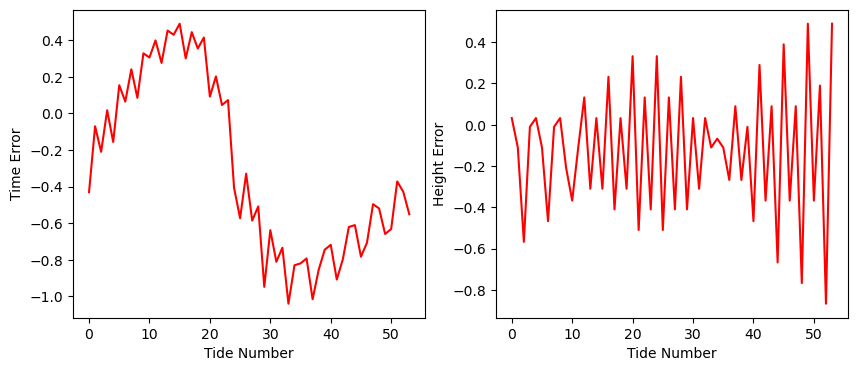

In [21]:
plt.gcf().set_size_inches((10, 4))
ax1 = plt.subplot(121)
plt.plot(compare_df["Time Error"], 'r')
plt.xlabel("Tide Number")
plt.ylabel("Time Error")
ax2 = plt.subplot(122, adjustable='box')
plt.plot(compare_df["Height Error"], 'r')
plt.xlabel("Tide Number")
plt.ylabel("Height Error")
plt.savefig("DonaghadeeSimpleErrors.pdf", bbox_inches='tight')